Adaptive Distances
==================

In this example, we show how and when to use the adaptive distances feature of pyabc. "Adaptive distances" means that the distance function is not pre-defined (e.g. after pre-processing), but evolves over time during the ABC run, depending on the observed summary statistics. This can be useful if different summary statistics vary on different scales, but it is not immediately clear how to weight them. For this case, in adaptive distances weights are adjusted in each iteration so as to balance the impact of all summary statistics on the computed distance. 

Currently, adaptively weighted p-norm distances (e.g. Euclidean) are implemented in pyABC, but it is easily possible to define arbitrary adaptive distances.

For illustration, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('DistanceFunction')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1*scipy.randn(),
            'ss2': 2 + 10*scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as1.db")
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=8, start_time=2018-05-08 15:12:33.721938, end_time=None)>
INFO:Epsilon:initial epsilon is 7.9738633089082125
INFO:ABC:t:0 eps:7.9738633089082125
INFO:ABC:t:1 eps:5.388418047354301
INFO:ABC:t:2 eps:3.1889646118912625
INFO:ABC:t:3 eps:2.2631158200056274
INFO:ABC:t:4 eps:1.503277339189326
INFO:ABC:t:5 eps:1.0766962153787059
INFO:ABC:t:6 eps:0.7379344693365135
INFO:ABC:t:7 eps:0.5449747279427112
INFO:History:Done <ABCSMC(id=8, start_time=2018-05-08 15:12:33.721938, end_time=2018-05-08 15:13:23.197959)>


Let us visualize the results for the non-adaptive distance:

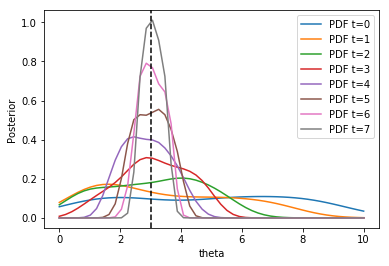

In [3]:
fig, ax = pyplot.subplots()
for t in range(history1.max_t + 1):
    df, w = history1.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

Second, we consider an adaptive Euclidean distance:

In [4]:
distance = pyabc.AdaptivePNormDistance(p=2, adaptive=True)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as2.db")
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=9, start_time=2018-05-08 15:13:23.739903, end_time=None)>
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.4073227245576903, 'ss2': 0.5926772754423099}
INFO:Epsilon:initial epsilon is 6.451862644929097
INFO:ABC:t:0 eps:6.451862644929097
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.5226092589671814, 'ss2': 0.4773907410328186}
INFO:ABC:t:1 eps:3.734755548195941
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.6042957874779633, 'ss2': 0.39570421252203664}
INFO:ABC:t:2 eps:2.3331715570446074
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.7164237193293286, 'ss2': 0.2835762806706716}
INFO:ABC:t:3 eps:1.4993404806915063
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.8281590332761515, 'ss2': 0.17184096672384835}
INFO:ABC:t:4 eps:0.8236799208199195
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.9049544790022588, 'ss2': 0.09504552099774108}
INFO:ABC:t:5 eps:0.43619913009360145
DEBUG:DistanceFuncti

In the debug output of abc.run above, it can be seen how the weights evolve over time. Let us visualize the results for the adaptive distance:

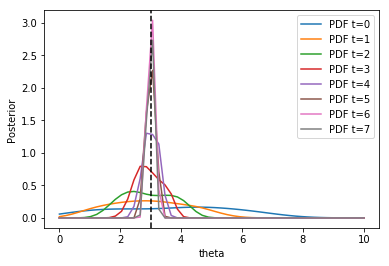

In [5]:
fig, ax = pyplot.subplots()
for t in range(history2.max_t + 1):
    df, w = history2.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

We observe differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$.

In detail, the adaptive distance feature works as follows: In each iteration of the ABCSMC run, after having obtained the desired number of accepted particles (and once at the beginning using a sample from the prior), the method ``DistanceFunction.update()`` is called. It is given a set of summary statistics which can be used to e.g. compute weights for the distance measure in the next iteration. In order to avoid bias, via ``DistanceFunction.configure_sampler()``, the distance function can tell the sampler to not only record accepted particles, but all that were generated during the sampling process.
So, when you want to define your own adaptive distance function, you will typically only need to overwrite these two methods. For implementation details and an example of how this can look in practise, please inspect the code of ``AdaptivePNormDistance``.